In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found - changed to inspector function
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# find all the columns in tables measurement
columns = inspector.get_columns("measurement")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# find all the columns in tables station
columns = inspector.get_columns("station")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
#Lets see how the tables look like
engine.execute("SELECT * FROM measurement LIMIT 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
engine.execute("SELECT * FROM station LIMIT 5").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Did NOT find any data after 2018-04-28. Find the max date and count down 12 mos
engine.execute("SELECT max(date) FROM measurement LIMIT 5").fetchall()

[('2017-08-23',)]

In [15]:
# Calculate the date 1 year ago from the last data point in the database
engine.execute("SELECT * FROM measurement where date >= '2016-08-23' LIMIT 5").fetchall()

[(2364, 'USC00519397', '2016-08-23', 0.0, 81.0),
 (2365, 'USC00519397', '2016-08-24', 0.08, 79.0),
 (2366, 'USC00519397', '2016-08-25', 0.08, 80.0),
 (2367, 'USC00519397', '2016-08-26', 0.0, 79.0),
 (2368, 'USC00519397', '2016-08-27', 0.0, 77.0)]

In [16]:
# Select only the date and prcp values
data_for_past_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').all()

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df_data_for_past_year = pd.DataFrame(data_for_past_year)
df_data_for_past_year = df_data_for_past_year.set_index("date")
df_data_for_past_year = df_data_for_past_year.rename(columns={"prcp":"precipitation"})
df_data_for_past_year.head(5)

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [18]:
# Sort the dataframe by date
df_data_for_past_year.sort_values(by="date", ascending=False, inplace=True)
df_data_for_past_year.head(5)

,precipitation
date,
2017-08-23,0.45
2017-08-23,0.08
2017-08-23,0.00
2017-08-23,0.00
2017-08-22,0.00


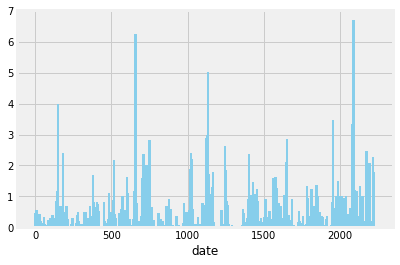

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
# Define X and Y axis
y = df_data_for_past_year["precipitation"]
x = np.arange(len(df_data_for_past_year.index))

plt.bar(x, y, width=15, color="skyblue", alpha=1, align="center")

# Set label
plt.xlabel("date")

plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_data_for_past_year.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
# Design a query to show how many stations are available in this dataset?
engine.execute("SELECT count(distinct id) FROM station").fetchall()

[(9,)]

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
engine.execute("SELECT station, count(*) FROM measurement group by station order by count(*) desc").fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Which station has the highest number of observations?
engine.execute("SELECT STATION FROM (SELECT station, count(*) FROM measurement group by station order by count(*) desc LIMIT 1)").fetchall()

[('USC00519281',)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
engine.execute("SELECT min(tobs), max(tobs), avg(tobs) FROM measurement where station = 'USC00519281'").fetchall()

[(54.0, 85.0, 71.66378066378067)]

In [25]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
past_year_data = session.query(Measurement.tobs).\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.tobs).all()

# past_year_data

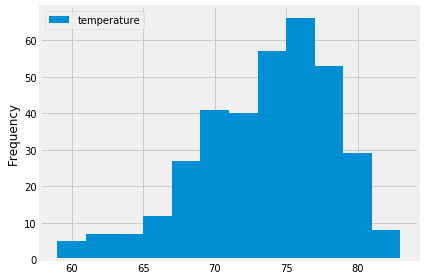

In [26]:
df_past_year_data = pd.DataFrame(past_year_data, columns=['temperature'])

df_past_year_data.plot.hist(bins=12)
plt.tight_layout()
plt.show()

In [27]:
# Import Flask
from flask import Flask
# Setup
app = Flask(__name__)

In [28]:
@app.route("/")
def index():
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/<start> <br/>"
        f"/api/v1.0/<start>/<end> <br/>"
    )

In [29]:
# Convert the query results to a Dictionary using date as the key and prcp as the value.
# Return the JSON representation of your dictionary.
@app.route("/api/v1.0/precipitation")
def precipitation():
    results = session.query(Measurement.date, Measurement.station, Measurement.prcp).\
    filter(Measurement.date > "2016-08-23").all()
    
    # Define the list
    station_precipitation = []
    for Measurement.date, Measurement.station, Measurement.prcp in results:
        precip_dict = {}
        precip_dict["date"] = Measurement.date
        precip_dict["station"] = Measurement.station
        precip_dict["prcp"] = Measurement.prcp
        station_precipitation.append(precip_dict)
    
    return jsonify(station_precipitation)

In [30]:
# /api/v1.0/stations
@app.route("/api/v1.0/stations")
def stations():
    station_list = session.query(Measurement.station).distinct()        
    return jsonify([station[0] for station in station_list])

In [31]:
# query for the dates and temperature observations from a year from the last data point.
# Return a JSON list of Temperature Observations (tobs) for the previous year.
@app.route("/api/v1.0/tobs")
def tobs():
    last_year_tobs = (session.query(Measurement.tobs).\
    filter(Measurement.date >= "2016-08-23").all())
    
    return jsonify(last_year_tobs)

In [32]:
# Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.
# When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.
# When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and end date inclusive.




In [33]:
if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with stat


SystemExit: 1

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
